# Exercise 4: Pretrained Neural Networks

## General Setup

In [1]:
# Important that this code block is only run once!
# Otherwise will need to restart kernel
from picamera2 import Picamera2
import timeit
import cv2
import numpy as np
import onnx
import onnxruntime as ort
import time
import matplotlib.pyplot as plt

# instantiate camera instance
picam2 = Picamera2()

[1:55:15.116274692] [4245]  INFO Camera camera_manager.cpp:284 libcamera v0.2.0+46-075b54d5
[1:55:15.143969895] [4264]  INFO RPI pisp.cpp:662 libpisp version v1.0.4 6e3a53d137f4 14-02-2024 (14:00:12)
[1:55:15.154161858] [4264]  INFO RPI pisp.cpp:1121 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx708@1a to CFE device /dev/media0 and ISP device /dev/media1 using PiSP variant BCM2712_C0
[1:55:15.155792506] [4245]  INFO Camera camera_manager.cpp:284 libcamera v0.2.0+46-075b54d5
[1:55:15.163804803] [4267]  INFO RPI pisp.cpp:662 libpisp version v1.0.4 6e3a53d137f4 14-02-2024 (14:00:12)
[1:55:15.173870766] [4267]  INFO RPI pisp.cpp:1121 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx708@1a to CFE device /dev/media0 and ISP device /dev/media1 using PiSP variant BCM2712_C0


### Exercise 2: 

In [2]:
# create a config with desired attributes: format, size, framerate
# NOTE: camera resolution 4608x2464, downsamples at 2304x1296 (56.03 fps)
# NOTE: XRGB8888 => shape: (height, width, 4); pixel value: [B, G, R, A]
config = picam2.create_preview_configuration(
    main={'format': 'XRGB8888', 'size': (2304, 1296)})  # 16:9 aspect ratio

# set camera configuration, start camera
picam2.configure(config)
picam2.start()

# start opencv window thread
cv2.startWindowThread()
wnd_name = 'foo'
cv2.namedWindow(wnd_name, cv2.WINDOW_KEEPRATIO)
cv2.resizeWindow(wnd_name, 640, 480)                    # 4:3 aspect ratio

while True:
    # get current image data from 'main' camera stream
    arr1 = picam2.capture_array('main')

    # resize the image data using bi-linear interpolation
    arr2 = cv2.resize(arr1, (640, 480), 0, 0, cv2.INTER_LINEAR)

    # if window closed, break loop before imshow creates new window
    if cv2.getWindowProperty(wnd_name, cv2.WND_PROP_AUTOSIZE) == -1:
        break

    # show resized image
    cv2.imshow(wnd_name, arr2)
    key = cv2.waitKey(1)

    if key == ord("q"):
        break

# stop camera
cv2.destroyWindow(wnd_name)
picam2.stop()


[1:55:18.290257449] [4245]  INFO Camera camera.cpp:1183 configuring streams: (0) 2304x1296-XRGB8888 (1) 2304x1296-BGGR16_PISP_COMP1
[1:55:18.290402542] [4267]  INFO RPI pisp.cpp:1405 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx708@1a - Selected sensor format: 2304x1296-SBGGR10_1X10 - Selected CFE format: 2304x1296-PC1B


### Exercise 3

6.	Exercise 3: Transforming images for inference using software.  
    a.	libcamera document:  
    b.	OpenCV package (maybe Numpy package too)  
    c.	Native resolution: 3280x2264, half this  
    d.	tiling, resizing, scaling, letterboxing (lecture 3 need to cover these topics)  
    e.	Changing packing scheme  
    f.	Goal: 3x416x416 (in RGB order, no alpha)  
    g.	Provide code for three different options  
    h.	Provide preprocessing code provided from ONNX model zoo page.  


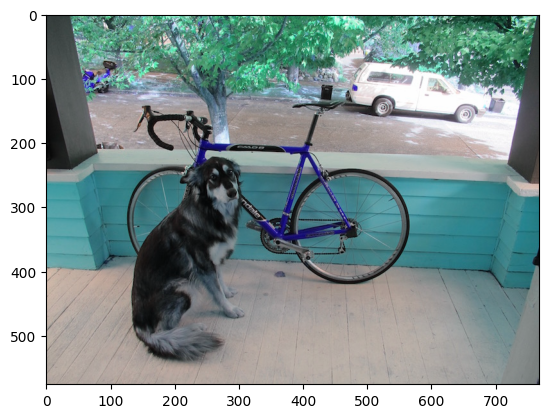

In [3]:
# Load and display test image

# open test image
arr1 = cv2.imread('../data/dog.jpg')  # default: bgr for display
plt.imshow(arr1)
plt.show()

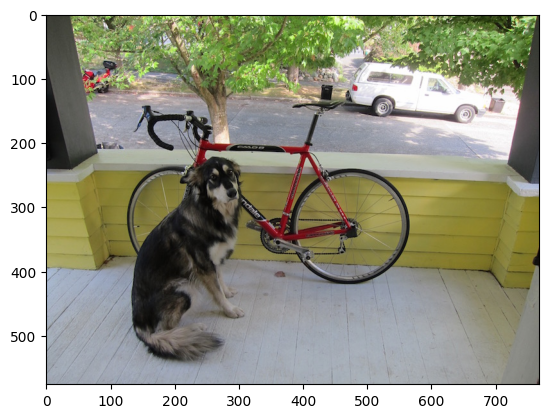

In [4]:
# Use openCV to reverse channel order
plt.imshow(cv2.cvtColor(arr1, cv2.COLOR_BGR2RGB))
plt.show()

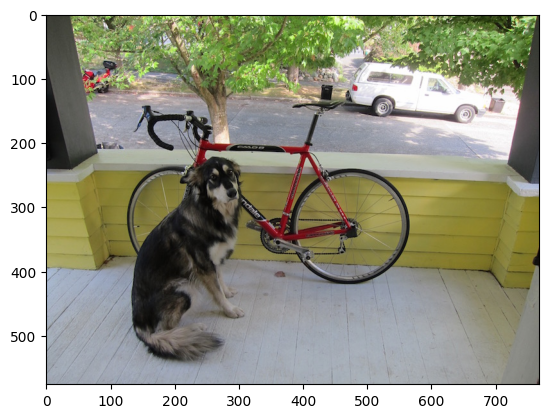

In [5]:
# Convert channels a different way

arr2 = arr1[..., ::-1]                  # bgr -> rgb for inference
plt.imshow(arr2)
plt.show()

In [17]:
# letterbox procedure
def letterbox(src, dest_shape):
    # get src dims
    src_width = src.shape[1]    # img.shape returns tuple (rows, cols, chan)
    src_height = src.shape[0]   # NOTE: rows => height; cols => width

    # cons dest array (filled with gray), get dest dims
    # NOTE: each 32-bit [B, G, R, A] pixel value is [128, 128, 128, 255]
    dest = np.full(dest_shape, np.uint8(128))
    if dest_shape[2] > 3:
        dest[:, :, 3] = np.uint8(255)
    dest_width = dest.shape[1]
    dest_height = dest.shape[0]

    # calculate width and height ratios
    width_ratio = dest_width / src_width        # NOTE: ratios are float values
    height_ratio = dest_height / src_height

    # init resized image width and height with max values (dest dims)
    rsz_width = dest_width
    rsz_height = dest_height

    # smallest scale factor will scale other dimension as well
    if width_ratio < height_ratio:
        rsz_height = int(src_height * width_ratio)  # NOTE: integer truncation
    else:
        rsz_width = int(src_width * height_ratio)

    # resize the image data using bi-linear interpolation
    rsz_dims = (rsz_width, rsz_height)
    rsz = cv2.resize(src, rsz_dims, 0, 0, cv2.INTER_LINEAR)

    # embed rsz into the center of dest
    dx = int((dest_width - rsz_width) / 2)          # NOTE: integer truncation
    dy = int((dest_height - rsz_height) / 2)
    dest[dy:dy+rsz_height, dx:dx+rsz_width, :] = rsz

    # letterboxing complete, return dest
    return dest

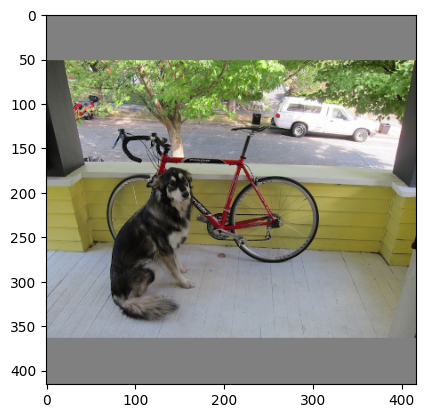

In [18]:
# letterbox the image to resize for NN input (size: (height, width, chan))
letterbox_img = letterbox(arr2, (416, 416, 3))
plt.imshow(letterbox_img)
plt.show()

In [25]:
# # pack_buffer procedure, ONNX model expects normalized float32 NCHW tensor
# def pack_buffer(src):
#     dest = np.array(src, dtype='float32')       # cons dest array via copy
#     dest = dest[:, :, :3]                       # remove alpha channel
#     dest = dest[..., ::-1]                      # reorder channels: BGR -> RGB
#     dest /= 255.0                               # normalize vals
#     dest = np.transpose(dest, [2, 0, 1])        # make channel first dim
#     dest = np.expand_dims(dest, 0)              # ins batch dim before chan dim
#     return dest


# pack_buffer procedure, ONNX model expects normalized float32 NCHW tensor
def pack_buffer(src):
    dest = np.array(src, dtype='float32')       # cons dest array via copy
    if dest.shape[3] > 3:
        dest = dest[:,:,:3]                     # if there is an alpha channel, remove it
    #dest = dest [..., ::-1]                     # reorder channels BGR -> RGB
    dest /= 255.0                               # normalize vals
    dest = np.transpose(dest, [2, 0, 1])        # make channel first dim
    dest = np.expand_dims(dest, 0)              # ins batch dim before chan dim
    return dest

In [28]:
buffered_img = pack_buffer(arr2)
buffered_img.shape

(1, 3, 576, 768)

In [ ]:
# create a config with desired attributes: format, size, framerate
# NOTE: camera resolution 4608x2464, downsamples at 2304x1296 (56.03 fps)
# NOTE: XRGB8888 => shape: (height, width, 4); pixel value: [B, G, R, A]
config = picam2.create_preview_configuration(
    main={'format': 'XRGB8888', 'size': (2304, 1296)})  # 16:9 aspect ratio

# set camera configuration, start camera
picam2.configure(config)
picam2.start()

# start opencv window thread
cv2.startWindowThread()
wnd_name = 'foo'
cv2.namedWindow(wnd_name, cv2.WINDOW_KEEPRATIO)
cv2.resizeWindow(wnd_name, 416, 416)                    # 1:1 aspect ratio

while True:
    # get current image data from 'main' camera stream
    arr1 = picam2.capture_array('main')

    # letterbox the image to resize for NN input (size: (height, width, chan))
    arr2 = letterbox(arr1, (416, 416, 4))

    # cons packed input buffer for ONNX model inference
    arr3 = pack_buffer(arr2)
    dim3 = np.array([arr2.shape[1],arr2.shape[0]],dtype=np.float32).reshape(1,2)

    # run ONNX model inference on input buffer to get results
    # res = infer(arr3, dim3)

    # process results to make list of annotations
    # annos = proc_results(res)

    # draw list of annotations on letterboxed image
    # arr4 = draw_annos(annos, arr2)

    # if window closed, break loop before imshow creates new window
    if cv2.getWindowProperty(wnd_name, cv2.WND_PROP_AUTOSIZE) == -1:
        break

    # show annotated image
    # cv2.imshow(wnd_name, arr4)
    cv2.imshow(wnd_name, arr2)
    
    key = cv2.waitKey(1)
    if key == ord("q"):
        break

# stop camera
cv2.destroyWindow(wnd_name)
picam2.stop()

### Exercise 4

4. Pre-Trained Neural Networks (PTNNs)
    a.	PTNNs have architecture and trained weights.  
    b.	Getting trained Tiny YOLOv3 from ONNX model zoo  
    c.	Consider NETRON model viewer (https://github.com/lutzroeder/netron)  
    d.	onnx2torch module  
    e.	Loading ONNX model into pytorch  
    f.	Run on a test image look at output: bbox center and extent, objectness, classifications.  
    g.	NOTE: use a very busy test image -> lots of bounding boxes  
    h.	[raw Yolo output is just numbers, not an image, what does it mean? Cue lecture 5  


In [ ]:
import onnx
import onnxruntime as ort

In [ ]:
# letterbox procedure
def letterbox(src, dest_shape):
    # get src dims
    src_width = src.shape[1]    # img.shape returns tuple (rows, cols, chan)
    src_height = src.shape[0]   # NOTE: rows => height; cols => width

    # cons dest array (filled with gray), get dest dims
    # NOTE: each 32-bit [B, G, R, A] pixel value is [128, 128, 128, 255]
    dest = np.full(dest_shape, np.uint8(128))
    dest[:, :, 3] = np.uint8(255)
    dest_width = dest.shape[1]
    dest_height = dest.shape[0]

    # calculate width and height ratios
    width_ratio = dest_width / src_width        # NOTE: ratios are float values
    height_ratio = dest_height / src_height

    # init resized image width and height with max values (dest dims)
    rsz_width = dest_width
    rsz_height = dest_height

    # smallest scale factor will scale other dimension as well
    if width_ratio < height_ratio:
        rsz_height = int(src_height * width_ratio)  # NOTE: integer truncation
    else:
        rsz_width = int(src_width * height_ratio)

    # resize the image data using bi-linear interpolation
    rsz_dims = (rsz_width, rsz_height)
    rsz = cv2.resize(src, rsz_dims, 0, 0, cv2.INTER_LINEAR)

    # embed rsz into the center of dest
    dx = int((dest_width - rsz_width) / 2)          # NOTE: integer truncation
    dy = int((dest_height - rsz_height) / 2)
    dest[dy:dy+rsz_height, dx:dx+rsz_width, :] = rsz

    # letterboxing complete, return dest
    return dest

# pack_buffer procedure, ONNX model expects normalized float32 NCHW tensor
def pack_buffer(src):
    dest = np.array(src, dtype='float32')       # cons dest array via copy
    dest = dest[:, :, :3]                       # remove alpha channel
    dest = dest[..., ::-1]                      # reorder channels: BGR -> RGB
    dest /= 255.0                               # normalize vals
    dest = np.transpose(dest, [2, 0, 1])        # make channel first dim
    dest = np.expand_dims(dest, 0)              # ins batch dim before chan dim
    return dest

In [ ]:
# cons ONNX Tiny YOLOv3 NN model
onnx_model_path = '../model/yolov3-tiny.onnx'
infer_sess = ort.InferenceSession(onnx_model_path)

In [ ]:


# instantiate camera instance
#picam2 = Picamera2()

# create a config with desired attributes: format, size, framerate
# NOTE: camera resolution 4608x2464, downsamples at 2304x1296 (56.03 fps)
# NOTE: XRGB8888 => shape: (height, width, 4); pixel value: [B, G, R, A]
config = picam2.create_preview_configuration(
    main={'format': 'XRGB8888', 'size': (2304, 1296)})  # 16:9 aspect ratio

# set camera configuration, start camera
picam2.configure(config)
picam2.start()

# start opencv window thread
cv2.startWindowThread()
wnd_name = 'foo'
cv2.namedWindow(wnd_name, cv2.WINDOW_KEEPRATIO)
cv2.resizeWindow(wnd_name, 416, 416)                    # 1:1 aspect ratio

while True:
    # get current image data from 'main' camera stream
    arr1 = picam2.capture_array('main')

    # letterbox the image to resize for NN input (size: (height, width, chan))
    arr2 = letterbox(arr1, (416, 416, 4))

    # cons packed input buffer for  model inference
    arr3 = pack_buffer(arr2)
    dim3 = np.array([arr2.shape[1],arr2.shape[0]],dtype=np.float32).reshape(1,2)

    # run ONNX model inference on input buffer to get results
    res = infer_sess.run(None, {'input_1': arr3, 'image_shape': dim3})

    # process results to make list of annotations
    # annos = proc_results(res)

    # draw list of annotations on letterboxed image
    # arr4 = draw_annos(annos, arr2)

    # if window closed, break loop before imshow creates new window
    if cv2.getWindowProperty(wnd_name, cv2.WND_PROP_AUTOSIZE) == -1:
        break

    # show annotated image
    # cv2.imshow(wnd_name, arr4)
    cv2.imshow(wnd_name, arr2)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break

# stop camera
cv2.destroyWindow(wnd_name)
picam2.stop()
